## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
display(train.describe())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


,age_approx,target,tfrecord,width,height,patient_code
count,33058.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000
mean,48.870016,0.017630,6.894826,4039.630381,2678.758256,734.894977
std,14.380360,0.131603,4.390486,2109.145590,1437.617626,528.907365
min,0.000000,0.000000,-1.000000,640.000000,480.000000,0.000000
25%,40.000000,0.000000,3.000000,1872.000000,1053.000000,271.000000
50%,50.000000,0.000000,7.000000,5184.000000,3456.000000,659.000000
75%,60.000000,0.000000,11.000000,6000.000000,4000.000000,1109.000000
max,90.000000,1.000000,14.000000,6000.000000,6000.000000,2055.000000


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
test['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
# anatom_site_general_challenge (NaN)
# train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
target_mean = train['target'].mean()
# Sex
sex_mean = train.groupby(['sex'])['target'].mean().reset_index().rename(columns={'target': 'sex_mean'})
train = train.merge(sex_mean, on=['sex'], how='left')
test = test.merge(sex_mean, on=['sex'], how='left')
train['sex_mean'].fillna(target_mean, inplace=True)
test['sex_mean'].fillna(target_mean, inplace=True)

# Age
age_mean = train.groupby(['age_approx'])['target'].mean().reset_index().rename(columns={'target': 'age_mean'})
train = train.merge(age_mean, on=['age_approx'], how='left')
test = test.merge(age_mean, on=['age_approx'], how='left')
train['age_mean'].fillna(target_mean, inplace=True)
test['age_mean'].fillna(target_mean, inplace=True)

# Sex_Age
sex_age_mean = train.groupby(['sex', 'age_approx'])['target'].mean().reset_index().rename(columns={'target': 'sex_age_mean'})
train = train.merge(sex_age_mean, on=['sex', 'age_approx'], how='left')
test = test.merge(sex_age_mean, on=['sex', 'age_approx'], how='left')
train['sex_age_mean'].fillna(target_mean, inplace=True)
test['sex_age_mean'].fillna(target_mean, inplace=True)

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,sex_enc,sex_mean,age_mean,sex_age_mean
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0,1,0.021231,0.011910,0.011664
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1,0,0.013766,0.011910,0.012232
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2,0,0.013766,0.012412,0.008646
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3,0,0.013766,0.011910,0.012232
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4,0,0.013766,0.016736,0.017094


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean,age_mean,sex_age_mean
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.021231,0.029472,0.033141
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.021231,0.006711,0.007316
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.013766,0.016736,0.017094
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.013766,0.012412,0.008646
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.013766,0.011910,0.012232


# Model

In [6]:
features = ['age_approx', 'sex_mean', 'age_mean', 'sex_age_mean']

enc_features  = [col for col in train.columns if 'enc' in col]

features += enc_features

# External features
# features += ext_fts
print(features)

['age_approx', 'sex_mean', 'age_mean', 'sex_age_mean', 'sex_enc']


In [7]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 12, 2)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[train['tfrecord'].isin(idxT)]
        x_valid = train[~train['tfrecord'].isin(idxT)]
        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.7min finished


Best: 0.685981 using {'subsample': 0.5, 'scale_pos_weight': 49.64231354642314, 'reg_lambda': 0.16326530612244897, 'reg_alpha': 0.5714285714285714, 'max_depth': 2, 'learning_rate': 0.007364413619537508, 'colsample_bytree': 0.8444444444444446}
0.672320 (0.021344) with: {'subsample': 0.7171717171717171, 'scale_pos_weight': 49.64231354642314, 'reg_lambda': 0.5918367346938775, 'reg_alpha': 0.36734693877551017, 'max_depth': 4, 'learning_rate': 0.023422900579365236, 'colsample_bytree': 0.45555555555555555}
0.668206 (0.023414) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 8, 'learning_rate': 0.11650307053484622, 'colsample_bytree': 1.0}
0.669281 (0.022007) with: {'subsample': 0.9797979797979799, 'scale_pos_weight': 13.160578386605785, 'reg_lambda': 0.4081632653061224, 'reg_alpha': 0.36734693877551017, 'max_depth': 10, 'learning_rate': 0.12775485451762533, 'colsample_bytree': 0.5333333

# Training

In [8]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'train' if x['tfrecord'] in idxT else 'validation', axis=1)
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], eval_metric='auc', verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Model evaluation

In [9]:
def func(x):
    if x['fold_1'] == 'validation':
        return x['pred_fold_1']
    elif x['fold_2'] == 'validation':
        return x['pred_fold_2']
    elif x['fold_3'] == 'validation':
        return x['pred_fold_3']
    elif x['fold_4'] == 'validation':
        return x['pred_fold_4']
    elif x['fold_5'] == 'validation':
        return x['pred_fold_5']
    
train['pred'] = train.apply(lambda x: func(x), axis=1)

auc_oof = roc_auc_score(train['target'], train['pred'])
print(f'Overall OOF AUC = {auc_oof:.3f}')

df_oof = train[['image_name', 'target', 'pred']]
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC = 0.681


,image_name,target,pred
0,ISIC_2637011,0,0.449205
1,ISIC_0015719,0,0.444155
2,ISIC_0052212,0,0.405665
3,ISIC_0068279,0,0.444155
4,ISIC_0074268,0,0.469115


,count,mean,std,min,25%,50%,75%,max
target,33126.0,0.017630,0.131603,0.000000,0.000000,0.000000,0.000000,1.000000
pred,33126.0,0.458191,0.072702,0.334612,0.397821,0.451577,0.495735,0.677833


# Feature importance

Fold: 1


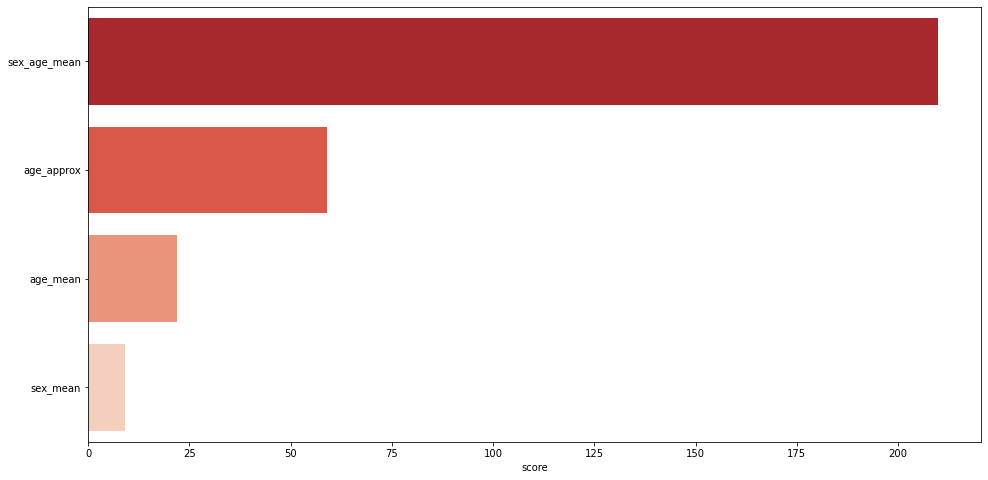

Fold: 2


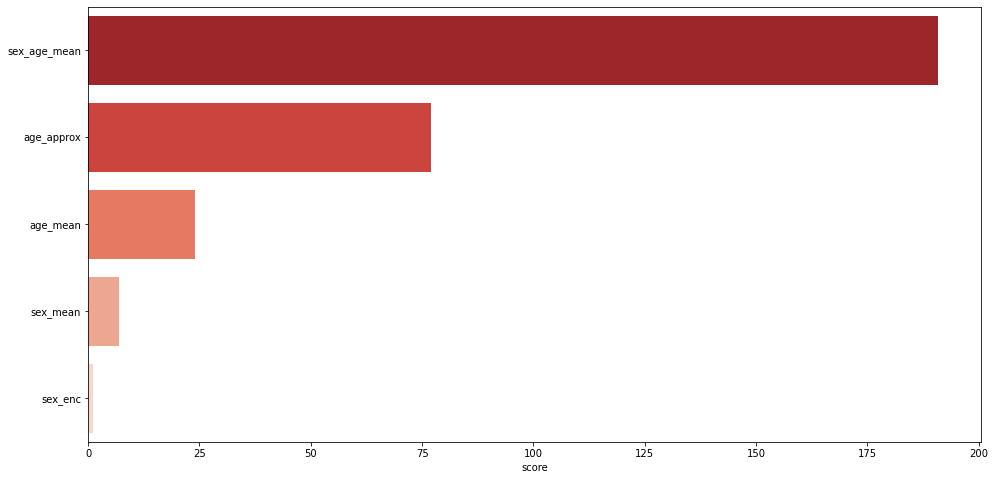

Fold: 3


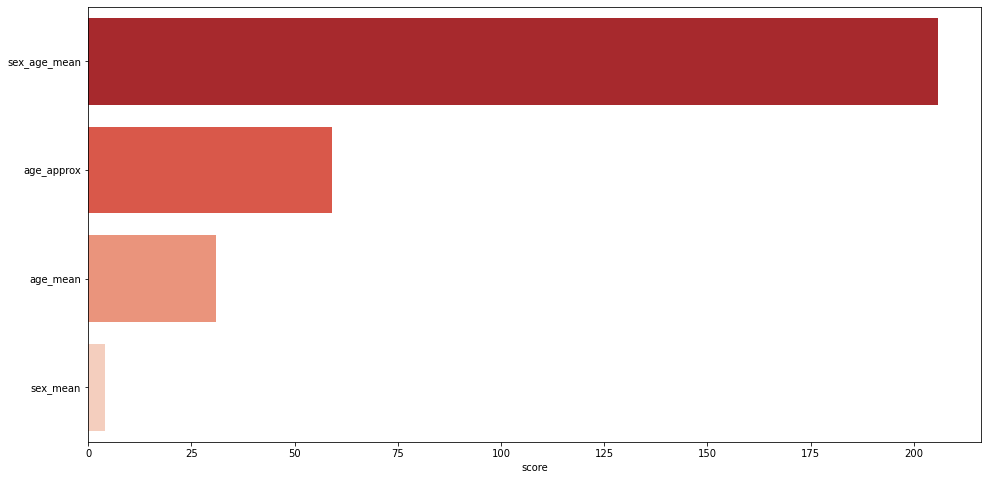

Fold: 4


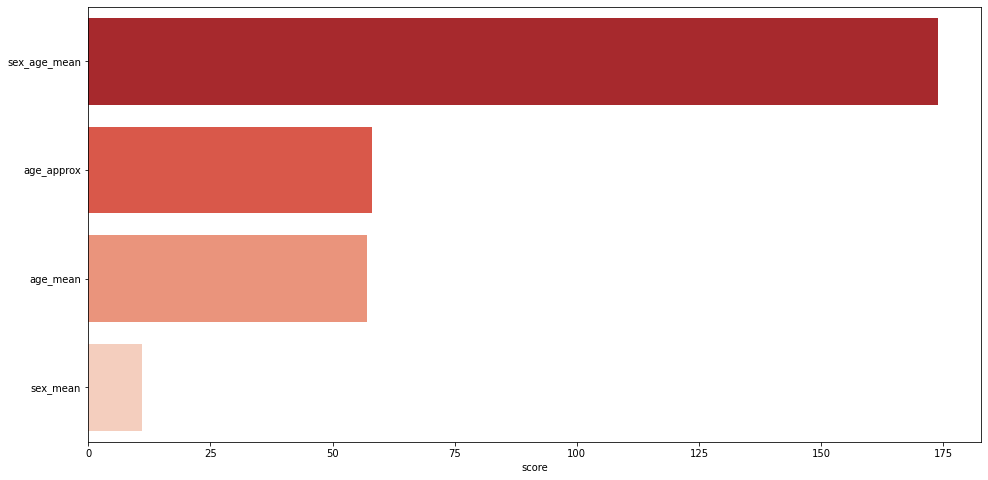

Fold: 5


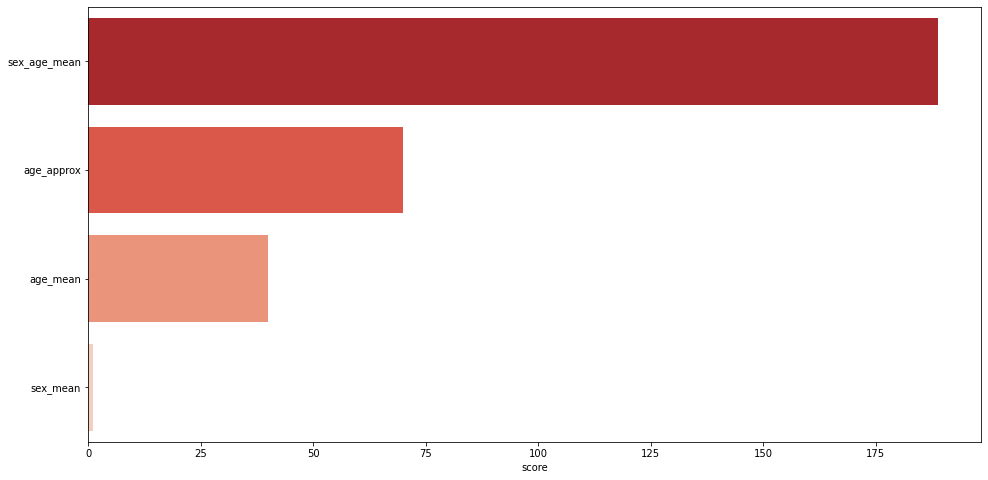

In [10]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [11]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.696124,0.687279,0.008846,0.694079,0.699333,0.692767,0.702411,0.689232,0.711296,0.705919,0.644905,0.698623,0.678448
Accuracy,0.758891,0.752261,0.006631,0.763955,0.744476,0.754263,0.791619,0.751492,0.713713,0.766398,0.746007,0.758350,0.765489
Precision,0.037871,0.035879,0.001992,0.038182,0.035235,0.035664,0.046290,0.037571,0.032787,0.039452,0.031321,0.038486,0.033763
Recall,0.514635,0.515196,-0.000561,0.507527,0.529412,0.492473,0.571429,0.526882,0.554622,0.520430,0.462185,0.525862,0.458333
F1-score,0.070548,0.067038,0.003510,0.071020,0.066072,0.066512,0.085642,0.070140,0.061914,0.073344,0.058667,0.071723,0.062893
Support,464.800000,119.200000,345.600000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,464.000000,120.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.696124,0.687279,0.008846,0.694079,0.699333,0.692767,0.702411,0.689232,0.711296,0.705919,0.644905,0.698623,0.678448
male,0.684003,0.677546,0.006456,0.680531,0.696184,0.663711,0.747364,0.693635,0.643819,0.686984,0.664222,0.695153,0.636143
female,0.688685,0.676620,0.012065,0.679354,0.712279,0.703045,0.621623,0.663347,0.760909,0.711673,0.589758,0.686007,0.698532
head/neck,0.770120,0.775081,-0.004961,0.777186,0.722381,0.751845,0.877618,0.773626,0.763529,0.768781,0.764009,0.779161,0.747867
upper extremity,0.708919,0.694767,0.014152,0.702142,0.723640,0.713175,0.684394,0.697968,0.718508,0.717675,0.653777,0.713634,0.693517
lower extremity,0.623838,0.618027,0.005812,0.624247,0.631448,0.628282,0.584005,0.620131,0.660840,0.627942,0.590881,0.618591,0.622960
torso,0.702798,0.691026,0.011772,0.695338,0.725873,0.697132,0.712393,0.700481,0.692432,0.713919,0.647418,0.707121,0.677015
0 <= age < 26,0.691378,0.658833,0.032546,0.701819,0.618644,0.755266,0.353630,0.665976,0.913194,0.649442,0.736787,0.684387,0.671907
26 <= age < 40,0.615093,0.606707,0.008387,0.607746,0.603127,0.611468,0.648743,0.627550,0.558934,0.633727,0.551972,0.594975,0.670758


# Adversarial Validation

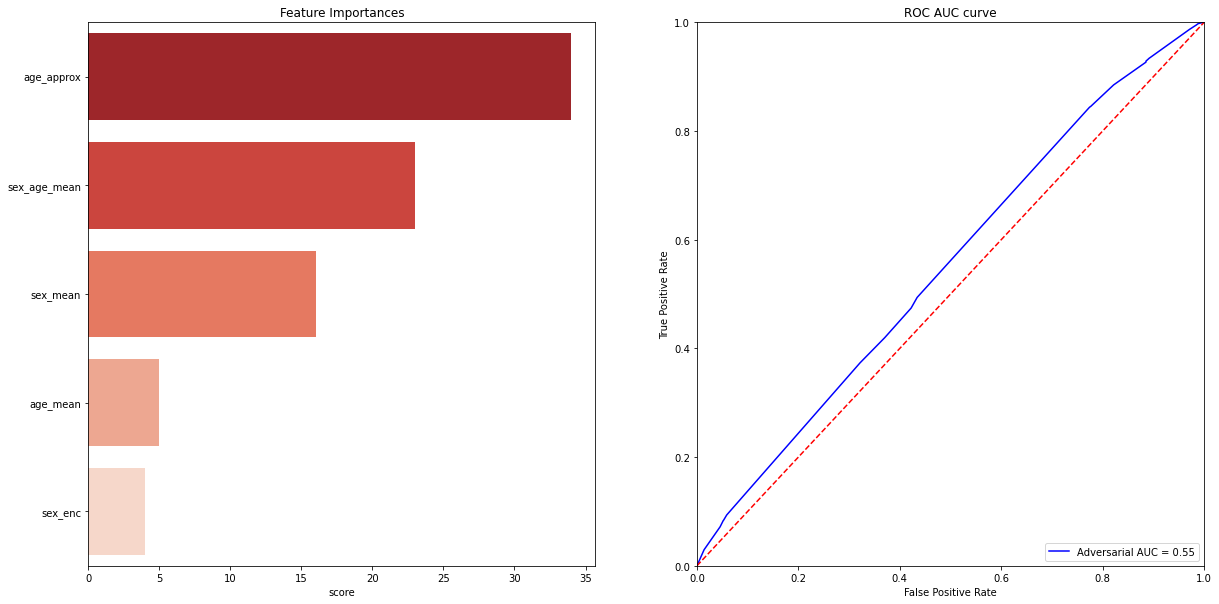

In [12]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [13]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 7969
Train positive correct predictions: 299
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.433333,0.449205,0.426348,0.437881,0.429049,0.424181
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.436764,0.444155,0.420857,0.442399,0.434699,0.441711
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.405767,0.397821,0.407007,0.424022,0.394319,0.405665
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.436764,0.444155,0.420857,0.442399,0.434699,0.441711
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.476098,0.469115,0.489949,0.462601,0.487392,0.471433
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.367865,0.370679,0.364928,0.370831,0.354189,0.378698
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.491377,0.499655,0.495735,0.505978,0.473813,0.481703
7,ISIC_0075663,female,35.0,torso,unknown,0,0.405102,0.405493,0.410229,0.420818,0.388400,0.400570
8,ISIC_0075914,male,30.0,torso,unknown,0,0.471978,0.486812,0.486884,0.465027,0.469587,0.451577
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.405767,0.397821,0.407007,0.424022,0.394319,0.405665


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.476098,0.469115,0.489949,0.462601,0.487392,0.471433
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.405767,0.397821,0.407007,0.424022,0.394319,0.405665
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.474547,0.467397,0.489968,0.462017,0.486612,0.466740
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.548518,0.543707,0.555517,0.555252,0.551223,0.536889
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.541487,0.532966,0.542830,0.549671,0.545843,0.536123
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.651217,0.661242,0.629815,0.650694,0.655048,0.659283
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.405102,0.405493,0.410229,0.420818,0.388400,0.400570
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.666668,0.677833,0.659221,0.665601,0.661423,0.669262
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.548518,0.543707,0.555517,0.555252,0.551223,0.536889
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.471978,0.486812,0.486884,0.465027,0.469587,0.451577


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
11,ISIC_0076742,male,75.0,upper extremity,unknown,0,0.651217,0.661242,0.629815,0.650694,0.655048,0.659283
14,ISIC_0077735,male,70.0,torso,unknown,0,0.561531,0.549908,0.560990,0.569818,0.564456,0.562484
17,ISIC_0079038,male,70.0,torso,unknown,0,0.561531,0.549908,0.560990,0.569818,0.564456,0.562484
18,ISIC_0080512,male,75.0,torso,unknown,0,0.651217,0.661242,0.629815,0.650694,0.655048,0.659283
24,ISIC_0082934,male,65.0,torso,unknown,0,0.548518,0.543707,0.555517,0.555252,0.551223,0.536889
26,ISIC_0084086,male,60.0,lower extremity,nevus,0,0.525646,0.526035,0.507807,0.545962,0.519960,0.528465
30,ISIC_0085718,female,65.0,torso,unknown,0,0.541487,0.532966,0.542830,0.549671,0.545843,0.536123
42,ISIC_0089738,female,70.0,torso,nevus,0,0.518995,0.512537,0.518925,0.520448,0.537686,0.505380
43,ISIC_0090279,female,65.0,torso,unknown,0,0.541487,0.532966,0.542830,0.549671,0.545843,0.536123
51,ISIC_0094775,male,75.0,torso,unknown,0,0.651217,0.661242,0.629815,0.650694,0.655048,0.659283


# Visualize test predictions

In [14]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 2775|8207
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.561531,0.549908,0.560990,0.569818,0.564456,0.562484
1,ISIC_0052349,male,40.0,lower extremity,0.382751,0.383644,0.387037,0.378616,0.383613,0.380847
2,ISIC_0058510,female,55.0,torso,0.476098,0.469115,0.489949,0.462601,0.487392,0.471433
3,ISIC_0073313,female,50.0,torso,0.405767,0.397821,0.407007,0.424022,0.394319,0.405665
4,ISIC_0073502,female,45.0,lower extremity,0.436764,0.444155,0.420857,0.442399,0.434699,0.441711
5,ISIC_0074618,male,50.0,lower extremity,0.462579,0.461798,0.476859,0.448916,0.468383,0.456937
6,ISIC_0076801,male,45.0,upper extremity,0.433333,0.449205,0.426348,0.437881,0.429049,0.424181
7,ISIC_0077586,male,50.0,lower extremity,0.462579,0.461798,0.476859,0.448916,0.468383,0.456937
8,ISIC_0082004,female,45.0,torso,0.436764,0.444155,0.420857,0.442399,0.434699,0.441711
9,ISIC_0082785,male,65.0,lower extremity,0.548518,0.543707,0.555517,0.555252,0.551223,0.536889


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.561531,0.549908,0.560990,0.569818,0.564456,0.562484
9,ISIC_0082785,male,65.0,lower extremity,0.548518,0.543707,0.555517,0.555252,0.551223,0.536889
11,ISIC_0087243,male,60.0,torso,0.525646,0.526035,0.507807,0.545962,0.519960,0.528465
13,ISIC_0089356,female,65.0,torso,0.541487,0.532966,0.542830,0.549671,0.545843,0.536123
17,ISIC_0095790,male,65.0,torso,0.548518,0.543707,0.555517,0.555252,0.551223,0.536889
24,ISIC_0112420,female,65.0,torso,0.541487,0.532966,0.542830,0.549671,0.545843,0.536123
26,ISIC_0115798,female,65.0,lower extremity,0.541487,0.532966,0.542830,0.549671,0.545843,0.536123
29,ISIC_0131485,male,70.0,NaN,0.561531,0.549908,0.560990,0.569818,0.564456,0.562484
31,ISIC_0131978,male,85.0,torso,0.599778,0.604147,0.619595,0.593103,0.575235,0.606811
36,ISIC_0148937,male,80.0,torso,0.666668,0.677833,0.659221,0.665601,0.661423,0.669262


# Test set predictions

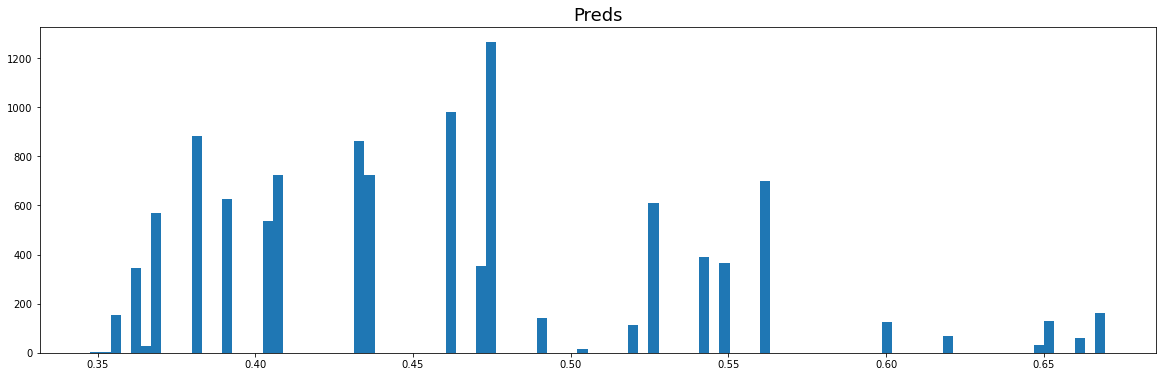

,image_name,target
0,ISIC_0052060,0.561531
1,ISIC_0052349,0.382751
2,ISIC_0058510,0.476098
3,ISIC_0073313,0.405767
4,ISIC_0073502,0.436764
5,ISIC_0074618,0.462579
6,ISIC_0076801,0.433333
7,ISIC_0077586,0.462579
8,ISIC_0082004,0.436764
9,ISIC_0082785,0.548518


,target
count,10982.000000
mean,0.459286
std,0.073155
min,0.347719
25%,0.405102
50%,0.461678
75%,0.518995
max,0.669391


In [15]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)